<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить  модель классифицировать комментарии на позитивные и негативные на имеющемся в  распоряжении наборе данных с разметкой о токсичности правок. Метрика качества модели *F1* должна быть не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Настройка ноутбука

In [ ]:
# !pip install wordcloud
# !pip install -U imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import re, time
from scipy.sparse import hstack

# ML libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# natural language processing
import spacy
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

# timing
from tqdm import notebook

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

# global variables
nlp = spacy.load('en_core_web_sm')
stopwords = set(stopwords.words('english'))
SEED = 777

### Загрузка данных

In [3]:
# загружаем данные
try:
    df = pd.read_csv('../01-data/toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('/datasets/toxic_comments.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


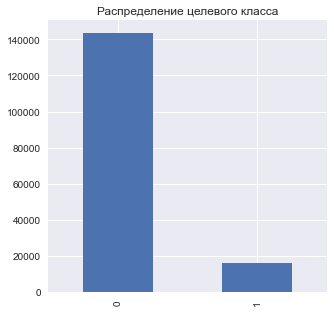

In [15]:
display(df.info())
display(df.head(3))
_ = df.toxic.value_counts().plot(kind='bar', figsize=(5, 5), title='Распределение целевого класса')

Проведем предварительную предобработку текста: уберем знак конца строки, посчитаем и добавим в качестве дополнительных признаков количество слов в объекте и количество знаков пунктуации. Удалять стоп слова не будем, их можно исключить при необходимости на стадии моделирования. 

In [17]:
%%time
df['text_clean'] = df['text'].apply(lambda x: re.sub('\n', '', x.lower()))
df['words_num'] = [len(str.split(t)) for t in df.iloc[:, 0]]
df['punct_num'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

CPU times: total: 5.97 s
Wall time: 6.34 s


In [63]:
df.describe()

,toxic,words_num,punct_num
count,159571.000000,159571.000000,159571.000000
mean,0.101679,67.273527,15.885418
std,0.302226,99.230702,36.649770
min,0.000000,1.000000,0.000000
25%,0.000000,17.000000,4.000000
50%,0.000000,36.000000,8.000000
75%,0.000000,75.000000,17.000000
max,1.000000,1411.000000,4942.000000


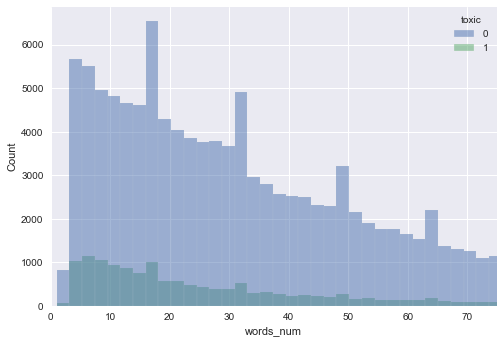

In [30]:
sns.histplot(df, x='words_num', hue='toxic')
plt.xlim(0, 75)
plt.title = 'Количество слов в сообщении'

In [8]:
df[df.punct_num > 2000]['toxic'].value_counts()

1    4
0    2
Name: toxic, dtype: int64

### Лемматизация

Проведем лемматизацию текста и сохраним обновленный датасет локально. <font color='red'>**Обработка занимает свыше 40 минут**, дальше можно загрузить уже обработанный файл из локальной копии.</font>

In [64]:
%%time
df['lemma'] = notebook.tqdm(df['text_clean']
                            .apply(lambda x: 
                            ' '.join([t.lemma_ for t in nlp(x)])))

  0%|          | 0/159571 [00:00<?, ?it/s]

CPU times: total: 43min 57s
Wall time: 47min 7s


In [ ]:
# сохраним результат в отдельном файле
df.to_pickle('lemmatized_data.pkl', compression="gzip")

In [2]:
# загрузка предобработанных данных из локальной копии
df = pd.read_pickle('lemmatized_data.pkl', compression="gzip")
df.head(5)

,text,toxic,text_clean,words_num,punct_num,lemma
0,Explanation\nWhy the edits made under my usern...,0,explanationwhy the edits made under my usernam...,43,10,explanationwhy the edit make under my username...
1,D'aww! He matches this background colour I'm s...,0,d'aww! he matches this background colour i'm s...,17,12,d'aww ! he match this background colour I be s...
2,"Hey man, I'm really not trying to edit war. It...",0,"hey man, i'm really not trying to edit war. it...",42,6,"hey man , I be really not try to edit war . it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"""morei can't make any real suggestions on impr...",113,21,""" morei can not make any real suggestion on im..."
4,"You, sir, are my hero. Any chance you remember...",0,"you, sir, are my hero. any chance you remember...",13,5,"you , sir , be my hero . any chance you rememb..."


Посмотрим какие слова чаще употребляются в сообщениях в зависимости от целевого признака.

<function matplotlib.pyplot.show(close=None, block=None)>

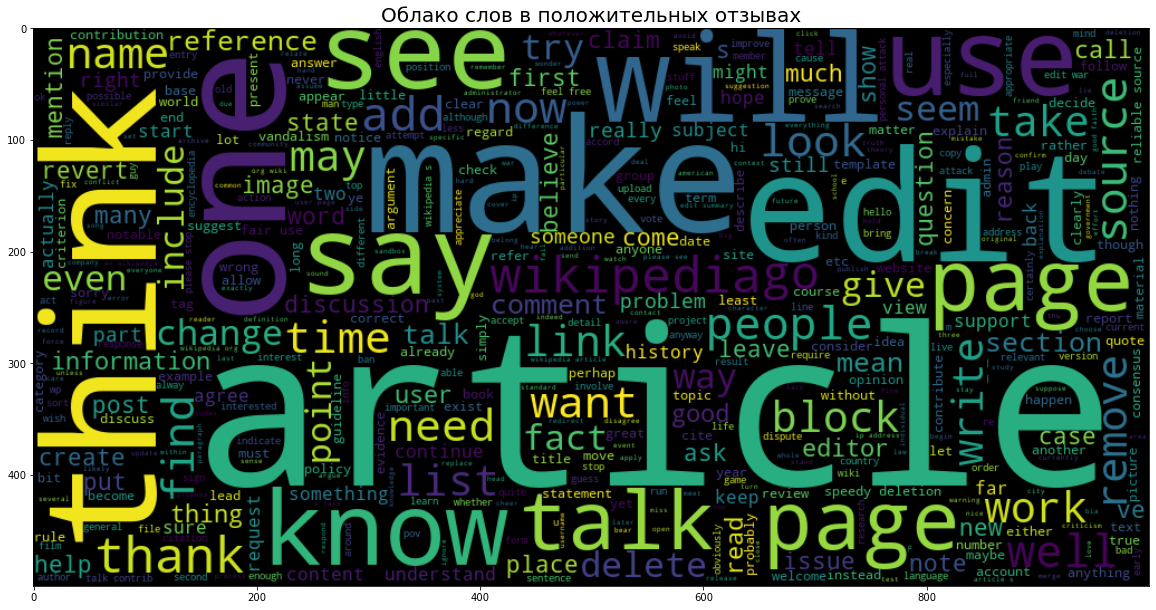

In [8]:
# облако для позитивных комментариев
plt.figure(figsize=(20,20))
positive_text = ' '.join(df.loc[df.toxic == 0]['lemma'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.title('Облако слов в положительных отзывах', fontdict={'fontsize':20})
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

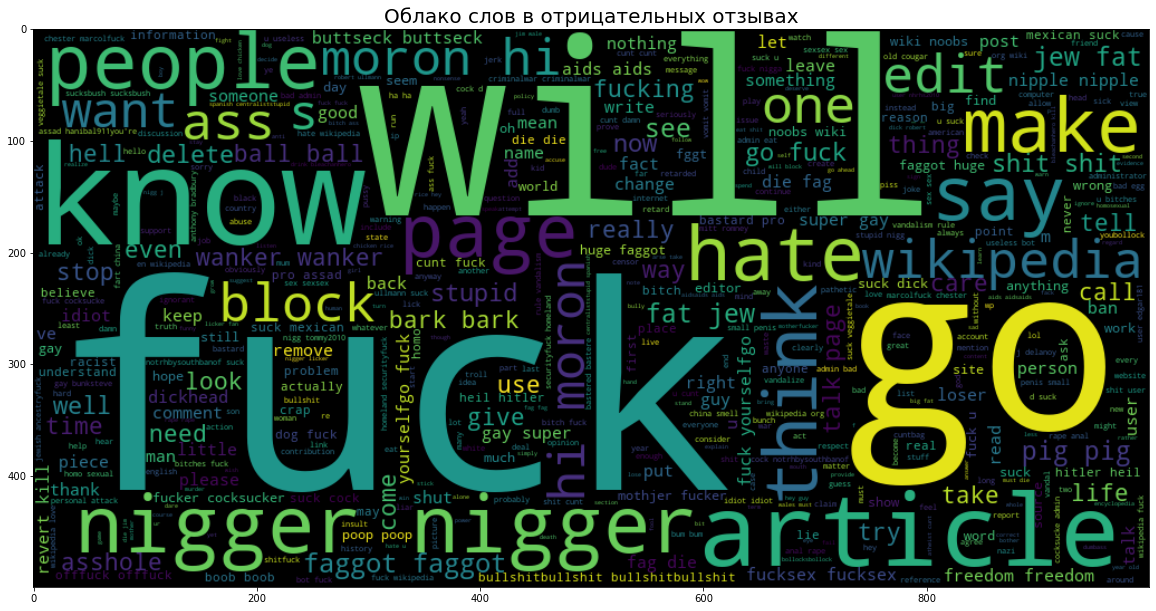

In [11]:
# облако для негативных комментариев
plt.figure(figsize=(20,20))
negative_text = ' '.join(df.loc[df.toxic == 1]['lemma'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words=WC.generate(negative_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.title('Облако слов в отрицательных отзывах', fontdict={'fontsize':20})
plt.show

В целом картинка дает представление о том, как люди выражают разные мнения. 

### Инструменты для обработки выборок

Создадим функцию для разбиения датасета на тренировочную (80%) и тестовые (20%) выборки. 

В процессе моделирования нам необходимо преобразовать текст в числовой вектор. Для этого будем рассчитывать для каждого слова в комментариях величину TF-IDF с помощью класса TfidfVectorizer() из библиотеки sklearn. По умолчанию передаем в класс ранее полученные леммы и дополнительные метапризнаки. Также по умолчанию установим следующие параметры для TfidfVectorizer():

- ngram_range=(1, 1) - N-грамма в одно слово
- min_df = 1 - порог встречаемости слова в корпусе, т.е. берем все
- max_features = None - берем все слова, встретившиеся в корпусе (можем ограничить каким-нибудь топом для улучшения производительности)
- stop_words=None - стоп-слова из библиотеки NTLK пока не удаляем

Дополнительно будем определять добавление наших метапризнаков - со стандартизацией (по умолчанию) и без нее.

После формирования нового датасета будем делить выборку на обучающую и тестовую в соотношении 8:2.

In [3]:
text_feat = ['lemma', 'text', 'text_clean']
meta_feat = ['words_num', 'punct_num']

def split_data(df, target='toxic', text_feat = text_feat[0], ext_feat=meta_feat):
    
    # Функция разделяет датасет на обучающую и тестовую выборки
    # features = ext_feat.append(text_feat)
    
    y = df[target]
    X = df[ext_feat + [text_feat]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                        test_size=0.2, random_state=SEED)
    print('Выборки для моделирования:')
    print(f'X_train: {X_train.shape}, y_train: {y_train.shape}, доля класса 1 - {sum(y_train) / len(y_train):.1%}')
    print(f'X_test: {X_test.shape}, y_test: {y_test.shape}, доля класса 1 - {sum(y_test) / len(y_test):.1%}')
    return X_train, X_test, y_train, y_test

### Итоги предварительного анализа

На данном этапе произведен анализ данных и предобработка текста для моделирования.  

В исходном датасете содержатся ~160 тысяч комментариев, десятая часть которых являются токсичными. Пропусков нет.

Мы добавили пару дополнительных метапризнаков, провели токенизацию и лемматизацию корпуса с помощью библиотеки spacy, сохранили результаты в файл (чтобы не тратить 40+ минут на повторную операцию) и написали функцию для разбиения датасета на обучающую и тестовую выборки. 


## Обучение

### Logistic regression

Проведем обучение с помощью модели логистической регрессии, создавая разные выборки. 

В процессе моделирования нам необходимо преобразовать текст в числовой вектор. Для этого будем рассчитывать для каждого слова в комментариях величину TF-IDF с помощью класса TfidfVectorizer() из библиотеки sklearn. По умолчанию в TfidfVectorizer()установлены следующие основные параметры:

- ngram_range=(1, 1) - N-грамма в одно слово
- min_df = 1 - порог встречаемости слова в корпусе, т.е. берем все
- stop_words=None - стоп-слова из библиотеки NTLK пока не удаляем
- max_features = None - берем все слова, встретившиеся в корпусе (можем ограничить каким-нибудь топом для улучшения производительности)

С последним параметром имеет смысл поработать, т.к. он кроме прочего также может снизить время на обучение модели.

В случае добавления метапризнаков их необходимо 

Вначале просто возьмем леммы и векторизуем их, не добавляя метапризнаки.

In [4]:
X_train, X_test, y_train, y_test = split_data(df)

Выборки для моделирования:
X_train: (127656, 3), y_train: (127656,), доля класса 1 - 10.2%
X_test: (31915, 3), y_test: (31915,), доля класса 1 - 10.1%


In [5]:
lr = LogisticRegression(solver='lbfgs', n_jobs=-1,
                        random_state=SEED, verbose=0)

In [15]:
ct = ColumnTransformer([('scaler', StandardScaler(), [0, 1]),
                        ('vectorizer', TfidfVectorizer(max_features=80000), 2)])


In [18]:
ct = ColumnTransformer([('vectorizer', TfidfVectorizer(max_features=80000), 2)])

In [19]:

lr_pipe = Pipeline([('column_transformer', ct),
                    ('model', LogisticRegression(C=1, tol=1e-3, n_jobs=-1,
                                                max_iter=100, random_state=SEED, verbose=0))])

In [20]:
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('vectorizer',
                                                  TfidfVectorizer(max_features=80000),
                                                  2)])),
                ('model',
                 LogisticRegression(C=1, n_jobs=-1, random_state=777,
                                    tol=0.001))])

f1_score = 0.7477


Text(0.5, 1.0, 'Confusion matrix')

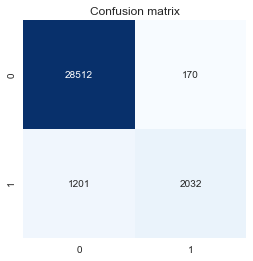

In [21]:
y_lr_pred = lr_pipe.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_lr_pred)

print(f'f1_score = {f1_score(y_test, y_lr_pred):.4f}')
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
plt.title('Confusion matrix')

Получили матрицу с почти 197 тысячей признаков, проверим результаты.

In [18]:
%%time
kf = KFold(n_splits=3, random_state=SEED, shuffle=True)
cross_val_score(lr, X_train, y_train, cv=kf, scoring='f1')

CPU times: total: 297 ms
Wall time: 13.8 s


array([0.71920904, 0.72752968, 0.71803653])

Метрика F1 пока не дотягивает до целевого значения. Подберем параметры модели по сетке.

In [9]:
lr_params = [
        {
            'C': [10, 50, 100, 200],
            'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
            'tol': [1e-03, 1e-04, 1e-05],
        }
]

In [ ]:
%%time
grid = GridSearchCV(lr, param_grid=lr_params, scoring='f1', cv=kf, verbose=False)
grid.fit(X_train, y_train)
# !!! операция занимает >40 минут

In [49]:
print(grid.best_score_)
print(grid.best_params_)  

0.775322212194066
{'C': 100, 'solver': 'lbfgs', 'tol': 0.001}


Уже получили удовлетворительный результат - 0.775. Обновим модель и дальше уже будем работать с этими параметрами.

In [25]:
lr = LogisticRegression(C=100, tol=1e-3, solver='lbfgs', n_jobs=-1,
                        random_state=SEED, verbose=0)

Попробуем улучшить модель:

1. Настроим количество признаков TF-IDF
2. Добавим в модель ранее полученные признаки частоты слов и знаков пунктуации.
3. Сбалансируем классы

In [11]:
%%time
for num_feat in range(30000, 110000, 10000):
    start = time.perf_counter()
    X_train, X_test, y_train, y_test = split_data(df,  
                                              ext_feat=None,
                                              v_max_features=num_feat,
                                              )
    score = cross_val_score(lr, X_train, y_train, cv=kf, scoring='f1').mean()
    train_time = time.perf_counter() - start
    print(f'Количество признаков: {num_feat:.0f}   |  F1-score: {score}')
    print(f'Время на разбиение выборок и кросс-валидацию: {train_time:.1f} с')
    print('-' * 60)


Выборки для моделирования:
X_train: (127656, 30000), y_train: (127656,), доля класса 1 - 10.2%
X_test: (31915, 30000), y_test: (31915,), доля класса 1 - 10.1%
Количество признаков: 30000   |  F1-score: 0.7723328463617086
Время на разбиение выборок и кросс-валидацию: 21.9 с
------------------------------------------------------------
Выборки для моделирования:
X_train: (127656, 40000), y_train: (127656,), доля класса 1 - 10.2%
X_test: (31915, 40000), y_test: (31915,), доля класса 1 - 10.1%
Количество признаков: 40000   |  F1-score: 0.7714606821298883
Время на разбиение выборок и кросс-валидацию: 22.0 с
------------------------------------------------------------
Выборки для моделирования:
X_train: (127656, 50000), y_train: (127656,), доля класса 1 - 10.2%
X_test: (31915, 50000), y_test: (31915,), доля класса 1 - 10.1%
Количество признаков: 50000   |  F1-score: 0.7710786097933894
Время на разбиение выборок и кросс-валидацию: 22.3 с
--------------------------------------------------------

Экспериментальным путем выяснили, что количество признаков TF-IDF лучше ограничить на уровне 80000. Добавим в данные метапризнаки.

In [15]:
X_train, X_test, y_train, y_test = split_data(df,  
                                            #   ext_feat=None,
                                              v_max_features=80000,
                                              )

Выборки для моделирования:
X_train: (127656, 80002), y_train: (127656,), доля класса 1 - 10.2%
X_test: (31915, 80002), y_test: (31915,), доля класса 1 - 10.1%


0.7215917490041489

In [20]:
cross_val_score(lr, X_train, y_train, cv=kf, scoring='f1').mean()

0.7828033172562918

Средняя метрика на кросс-валидации выросла до 0.78, следовательно метапризнаки немного улучшают модель.

В наших данных имеется существенная несбалансированность классов - негативные комментарии составляют чуть больше 10% от выборки. Попробуем апсемплировать тренировочные данные с помощью SMOTE - Synthetic Minority Oversampling Technique из библиотеки imbalanced-learn.

In [32]:
%%time
imba_pipeline = make_pipeline(SMOTE(random_state=SEED), MaxAbsScaler(), lr)
cross_val_score(imba_pipeline, X_train, y_train, scoring='f1', cv=kf).mean()

CPU times: total: 11.8 s
Wall time: 33.6 s


0.6797872298076951

Результат не удовлетворительный, причем не сильно помогло и дополнительное масштабирование признаков. Следовательно, наша лучшая модель - та, что получена на предыдущем шаге. Проверим ее на тестовой выборке.

f1_score = 0.7849
CPU times: total: 109 ms
Wall time: 7.16 s


Text(0.5, 1.0, 'Confusion matrix')

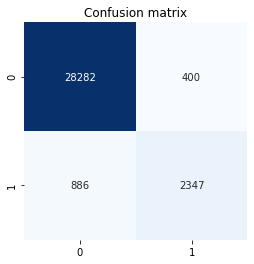

In [43]:
%%time
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_lr_pred)

print(f'f1_score = {f1_score(y_test, y_lr_pred):.4f}')
    
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
plt.title('Confusion matrix')

В целом результат удовлетворительный, попробуем также обучить линейную модель с использованием стохастического градиентного спуска (SGD).

### SGDClassifier

Используем тренировочную и тестовую выборке из последней модели логистической регрессии. Большую часть параметров классификатора возьмем по умолчанию (функция потерь - линейная машина опорных векторов).

In [50]:
%%time
sgd = SGDClassifier(alpha=1e-05, penalty='l1', random_state=SEED)
cross_val_score(sgd, X_train, y_train, cv=kf, scoring='f1').mean()

CPU times: total: 5.06 s
Wall time: 4.33 s


0.7658788456709509

In [48]:
float(1e-5)

1e-05

Результат положительный, но ниже чем у логистической регрессии. Проверим на тестовых данных.

f1_score = 0.7920
CPU times: total: 1.98 s
Wall time: 1.53 s


Text(0.5, 1.0, 'Confusion matrix')

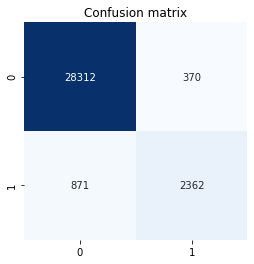

In [42]:
%%time
sgd.fit(X_train, y_train)
y_sgd_pred = sgd.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_sgd_pred)

print(f'f1_score = {f1_score(y_test, y_sgd_pred):.4f}')
    
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix,annot=True,cmap="Blues",fmt="d",cbar=False)
plt.title('Confusion matrix')

На тесте SGD показала лучший результат, при том, что мы не занимались детальной настройкой модели.

## Выводы

В данном проекте мы провели анализ корпуса комментариев с целью разработки модели их классификации на негативные и положительные. 

Мы очистили и лемматизировали комментарии, добавили статистические метапризнаки и подготовили данные для моделирования.

В ходе моделирования мы протестировали две модели - логистической регрессии и стохастический градиентный спуск.

На обучающих данных лучший результат показала модель логистической регрессии, однако на тестовых - лучший результат у SGD. При этом SGD обучается в разы быстрее.

Обе модели имеют потенциал для улучшения как с точки зрения настройки параметров, так и в настройке тестовых данных (например, мы задействовали не все настройки при созданию спарс-матрицы TD-IDF).

Лучший F1-score - 0.7920.